In [1]:
# Top2Vec Tweet Modeling Pipeline

# 1. Setup and Imports


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from top2vec import Top2Vec
from pysentimiento.preprocessing import preprocess_tweet




2025-05-21 11:04:33.840596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747814673.863407  576005 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747814673.870545  576005 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747814673.889726  576005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747814673.889748  576005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747814673.889751  576005 computation_placer.cc:177] computation placer alr

In [2]:
import nltk
nltk.data.path.append("/home/edennar/nltk_data")


In [3]:
import os
import yaml
import logging
import sqlite3
import pandas as pd
from top2vec import Top2Vec
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def setup_logging(log_file):
    logging.basicConfig(
        filename=log_file,
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        filemode='w'
    )

In [4]:
def load_config(path="top2vec_config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [5]:
def save_topic_summary_csv(topic_words, topic_nums, output_dir):
    import pandas as pd
    topic_df = pd.DataFrame({
        "topic_id": topic_nums,
        "top_words": [", ".join(words[:10]) for words in topic_words]
    })
    topic_df.to_csv(os.path.join(output_dir, "topics_info.csv"), index=False)

In [6]:
def save_wordclouds(topic_words, word_scores, topic_nums, output_dir):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    for i, topic_id in enumerate(topic_nums[:5]):
        words = topic_words[i][:30]
        scores = word_scores[i][:30]
        freq = dict(zip(words, scores))
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {topic_id}")
        plt.savefig(os.path.join(output_dir, f"wordcloud_topic_{topic_id}.png"))
        plt.close()

In [7]:
def save_topic_distribution_plot(topic_ids, topic_sizes, output_dir):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.bar(topic_ids, topic_sizes)
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Documents")
    plt.title("Topic Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "topic_distribution.png"))
    plt.close()

In [8]:
def save_topic_similarity_plot(model, output_dir):
    import matplotlib.pyplot as plt
    import numpy as np
    try:
        sim_matrix = getattr(model, "topic_sim_matrix", None)
        if sim_matrix is not None:
            plt.figure(figsize=(10, 8))
            plt.imshow(sim_matrix, cmap='viridis')
            plt.colorbar()
            plt.title("Topic Similarity Matrix")
            plt.xlabel("Topic")
            plt.ylabel("Topic")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "topic_similarity_matrix.png"))
            plt.close()
        else:
            logging.warning("topic_sim_matrix not found in model.")
    except Exception as e:
        logging.warning(f"Could not generate topic similarity plot: {e}")


In [9]:
def save_topic_hierarchy(model, output_dir):
    try:
        model.hierarchical_topic_reduction(num_topics=10)
        model.generate_topic_hierarchy(os.path.join(output_dir, "topic_hierarchy.html"))
    except Exception as e:
        logging.warning(f"Could not generate topic hierarchy: {e}")


In [10]:
def plot_stacked_topic_trends(df, topic_columns):
    if not topic_columns:
        print("⚠️ No topic columns found for plotting.")
        return

    # Ensure the 'month' column exists and is in correct format
    if "month" not in df.columns:
        df['month'] = pd.to_datetime(df['created_at'], errors='coerce').dt.to_period('M').dt.to_timestamp()

    # Filter to keep only numeric topic columns
    numeric_topic_cols = [col for col in topic_columns if pd.api.types.is_numeric_dtype(df[col])]
    if not numeric_topic_cols:
        print("⚠️ No numeric topic columns found for plotting.")
        return

    # Aggregate topic values by month
    monthly_topics = df.groupby('month')[numeric_topic_cols].sum()

    if monthly_topics.empty:
        print("⚠️ monthly_topics is empty. Nothing to plot.")
        return

    # Assign colors and plot
    colors = cm.tab20(np.linspace(0, 1, monthly_topics.shape[1]))
    monthly_topics.plot(kind='area', stacked=True, figsize=(14, 8), alpha=0.85, color=colors)

    plt.title("Topic Trends Over Time")
    plt.xlabel("Month")
    plt.ylabel("Topic Activity")
    plt.tight_layout()
    plt.show()

In [11]:


def save_topic_trend_plots(df, output_dir):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df['month'] = df['created_at'].dt.to_period('M').dt.to_timestamp()
    df = df.dropna(subset=["month"])

    # Line plot
    grouped = df.groupby(['month', 'topic']).size().reset_index(name='count')
    pivot = grouped.pivot(index='month', columns='topic', values='count').fillna(0)
    pivot.plot(figsize=(14, 6))
    plt.title("Topic Frequency Over Time")
    plt.xlabel("Month")
    plt.ylabel("Document Count")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "topic_trend_over_time.png"))
    plt.close()

    # Stacked area chart
    topic_cols = [col for col in df.columns if col.startswith("topic_")]
    monthly = df.groupby("month")[topic_cols].sum()
    colors = cm.tab20(np.linspace(0, 1, len(topic_cols)))
    monthly.plot(kind="area", stacked=True, figsize=(14, 8), color=colors, alpha=0.85)
    plt.title("Stacked Topic Trends")
    plt.xlabel("Month")
    plt.ylabel("Topic Counts")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "stacked_topic_trends.png"))
    plt.close()

In [12]:
def save_model_outputs(model, df_posts, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model.save(os.path.join(output_dir, "best_top2vec_model"))

    topic_words, word_scores, topic_nums = model.get_topics()
    topic_sizes, topic_ids = model.get_topic_sizes()
    topic_cols = [col for col in df_posts.columns if col.startswith("topic_")]

    # ✅ Fix: Ensure 'month' exists
    if "month" not in df_posts.columns:
        df_posts["month"] = pd.to_datetime(df_posts["created_at"], errors="coerce").dt.to_period("M")

    monthly = df_posts.groupby("month")[topic_cols].sum()

    save_topic_summary_csv(topic_words, topic_nums, output_dir)
    save_wordclouds(topic_words, word_scores, topic_nums, output_dir)
    save_topic_distribution_plot(topic_ids, topic_sizes, output_dir)
    save_topic_similarity_plot(model, output_dir)
    #save_topic_hierarchy(model, output_dir)
    plot_stacked_topic_trends(df_posts, topic_cols)

    df_posts["topic"] = model.doc_top
    df_posts.to_csv(os.path.join(output_dir, "tweets_with_topics.csv"), index=False)

    for topic_id in set(model.doc_top):
        df_posts[f'topic_{topic_id}'] = (model.doc_top == topic_id).astype(int)

    save_topic_trend_plots(df_posts, output_dir)


In [13]:
def tune_top2vec_models(documents, param_grid):
    results = []
    for emb in param_grid["embedding_model"]:
        for speed in param_grid["speed"]:
            logging.info(f"Training with embedding_model={emb}, speed={speed}")
            try:
                model = Top2Vec(
                    documents=documents,
                    speed=speed,
                    embedding_model=emb,
                    keep_documents=True
                )
                results.append({
                    "model": model,
                    "embedding_model": emb,
                    "speed": speed
                })
            except Exception as e:
                logging.error(f"Failed config: {emb}, {speed} | Error: {e}")

    best = results[0]
    logging.info(f"Best config: {best['embedding_model']} + {best['speed']}")
    return best["model"]

In [14]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize # Uncomment if you switch to word_tokenize
# from nltk.tag import pos_tag # Uncomment if using pos_tag more directly

# Ensure NLTK resources are downloaded and paths are set
# (It's good practice to manage NLTK data path consistently)
nltk_data_path = "/home/edennar/nltk_data" # As in your original notebook
nltk.data.path.append(nltk_data_path)

try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords', download_dir=nltk_data_path, quiet=True)
    stop_words = set(stopwords.words('english'))

try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet', download_dir=nltk_data_path, quiet=True)
try:
    nltk.data.find('taggers/averaged_perceptron_tagger.zip') # For pos_tag
except LookupError:
    nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_path, quiet=True)

lemmatizer = WordNetLemmatizer()





In [15]:
def get_wordnet_pos_internal(word):
    """Map POS tag to first character lemmatize() accepts.
       Helper for lemmatization."""
    # Ensure word is not empty and is a string
    if not word or not isinstance(word, str):
        return nltk.corpus.wordnet.NOUN # Default to noun if word is problematic
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN) # Default to noun

In [16]:
def preprocess_text_pipeline(text_series, pysentimiento_preprocess_tweet_func):
    # 1. Pysentimiento preprocessing
    # Pass the actual pysentimiento.preprocess_tweet function as an argument
    logging.info("Applying pysentimiento.preprocess_tweet...")
    # Consider using shorten, e.g., preprocess_tweet(text, shorten=2)
    # if you want to break up hashtags like #SomeTopic to "some topic"
    processed_series = text_series.apply(lambda x: pysentimiento_preprocess_tweet_func(x))

    # 2. Custom placeholder removal
    logging.info("Removing placeholders...")
    placeholders_to_remove = [
        r'\burl\b', r'\bemoji\b', r'\bhashtag\b', r'\b@user\b',
        r'\bnumber\b', r'\bhttps\b',
        r'\ben\b' # 'en' is debatable, could be a stopword or artifact.
                 # If it's a common English word, general stopword removal will catch it.
    ]
    pattern = r'|'.join(placeholders_to_remove)
    processed_series = processed_series.apply(lambda x: re.sub(pattern, '', x, flags=re.IGNORECASE))

    # 3. Remove "RT" prefix
    logging.info("Removing 'RT' prefix...")
    processed_series = processed_series.apply(lambda x: re.sub(r'^\s*rt\s+', '', x, flags=re.IGNORECASE).strip())


    # 4. Optional: Lemmatization (decide if you want this)
    # logging.info("Applying lemmatization (optional)...")
    # def lemmatize_internal(text):
    #     tokens = text.split() # or use nltk.word_tokenize(text)
    #     # Filter out empty strings that might result from previous steps before lemmatizing
    #     lemmatized_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos_internal(w)) for w in tokens if w]
    #     return " ".join(lemmatized_tokens)
    # processed_series = processed_series.apply(lemmatize_internal)


    # 5. Stop word removal
    logging.info("Removing stopwords...")
    def remove_stopwords_internal(text):
        words = text.split() # or use nltk.word_tokenize(text)
        # Also remove very short words (e.g., single characters left after other cleaning)
        # and ensure word is not empty before lowercasing
        filtered_words = [word for word in words if word and word.lower() not in stop_words and len(word) > 1]
        return " ".join(filtered_words)
    processed_series = processed_series.apply(remove_stopwords_internal)


    # 6. Clean up extra spaces
    logging.info("Cleaning up extra spaces...")
    processed_series = processed_series.apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    return processed_series

In [40]:
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

def compute_topic_coherence(model, raw_documents, coherence='c_v', top_n_words=10):
    
    logging.info("Computing topic coherence...")

    topic_words, _, _ = model.get_topics()
    topics_words = [[str(word) for word in topic[:top_n_words]] for topic in topic_words]

    tokenized_texts = [simple_preprocess(doc) for doc in raw_documents]
    dictionary = Dictionary(tokenized_texts)

    # Filter out topics with all words missing from dictionary
    valid_topics = []
    for i, topic in enumerate(topics_words):
        filtered = [word for word in topic if word in dictionary.token2id]
        if len(filtered) == 0:
            logging.warning(f"Skipping topic {i} – no words found in dictionary.")
        else:
            valid_topics.append(filtered)

    if not valid_topics:
        raise ValueError("No valid topics left after filtering out empty ones.")

    coherence_model = CoherenceModel(
        topics=valid_topics,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence=coherence
    )
    coherence_score = coherence_model.get_coherence()
    logging.info(f"Topic Coherence Score ({coherence}): {coherence_score:.4f}")
    return coherence_score



In [44]:
import matplotlib.pyplot as plt

def plot_coherence_vs_topn(model, raw_documents, topn_range=range(5, 21), coherence='c_v', output_path=None):
    from gensim.models import CoherenceModel
    from gensim.utils import simple_preprocess
    from gensim.corpora import Dictionary

    logging.info("Generating coherence plot...")

    tokenized_texts = [simple_preprocess(doc) for doc in raw_documents]
    dictionary = Dictionary(tokenized_texts)
    topic_words, _, _ = model.get_topics()

    scores = []
    valid_n = []

    for topn in topn_range:
        topics_words = [[str(word) for word in topic[:topn]] for topic in topic_words]

        valid_topics = []
        for topic in topics_words:
            filtered = [word for word in topic if word in dictionary.token2id]
            if filtered:
                valid_topics.append(filtered)

        if not valid_topics:
            continue

        cm = CoherenceModel(
            topics=valid_topics,
            texts=tokenized_texts,
            dictionary=dictionary,
            coherence=coherence
        )
        score = cm.get_coherence()
        scores.append(score)
        valid_n.append(topn)

        logging.info(f"Top {topn} words: Coherence = {score:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(valid_n, scores, marker='o')
    plt.title(f"Topic Coherence vs. Top-N Words ({coherence})")
    plt.xlabel("Top-N Words per Topic")
    plt.ylabel("Coherence Score")
    plt.grid(True)
    plt.tight_layout()

    # Save if requested
    if output_path:
        plt.savefig(output_path)
        logging.info(f"Coherence plot saved to {output_path}")

    plt.show()


In [45]:
def main():
    # Load config and setup logging
    config = load_config()
    setup_logging(config["log_file"]) # Make sure setup_logging is defined in an earlier cell
    logging.info("Starting Top2Vec run.")

    # 1. Load all data from SQLite
    conn = sqlite3.connect("New_Fire_DB.db") # Ensure sqlite3 is imported
    query = """
    SELECT tweet_id, user_screen_name AS author, full_text AS content, user_verified AS label, created_at
    FROM posts
    WHERE full_text IS NOT NULL;
    """
    df = pd.read_sql_query(query, conn) # Ensure pandas as pd is imported
    conn.close()
    logging.info(f"Loaded {len(df)} tweets from database.")

    # 2. Clean and preprocess
    df["content"] = df["content"].astype(str)
    # The UserWarning about date parsing is from here. Specifying a format can help if known.
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

    # Apply the preprocessing pipeline
    # Pass the actual pysentimiento.preprocess_tweet function
    df["clean_content"] = preprocess_text_pipeline(df["content"], preprocess_tweet)
    logging.info("Completed text preprocessing pipeline.")

    # Filter out tweets that became empty or too short after cleaning
    min_word_count = 3 # Example threshold
    original_count = len(df)
    df = df[df["clean_content"].apply(lambda x: len(x.split()) >= min_word_count)]
    # Also ensure content is not just whitespace
    df = df[df["clean_content"].str.strip().astype(bool)].reset_index(drop=True)
    logging.info(f"Filtered out {original_count - len(df)} tweets; {len(df)} remaining after length/empty check.")


    if df.empty:
        logging.error("No documents available for training after preprocessing and filtering. Exiting.")
        return

    # Apply max_docs *after* filtering
    max_docs_to_use = config.get("max_docs", len(df)) # Use all if max_docs not in config
    df = df.head(max_docs_to_use)
    logging.info(f"Using {len(df)} documents for Top2Vec model training (max_docs).")


    documents = df["clean_content"].tolist()

    if not documents:
        logging.error(f"No documents available after applying max_docs. Exiting.")
        return

    # Ensure Top2Vec and other model-related functions are defined/imported earlier
    model = tune_top2vec_models(documents, config["param_grid"])
    save_model_outputs(model, df, config["output_dir"])
   

    # Compute and log coherence score
    coherence_score = compute_topic_coherence(model, df["content"].tolist())
    with open(os.path.join(config["output_dir"], "coherence_score.txt"), "w") as f:
        f.write(f"Topic Coherence Score (c_v): {coherence_score:.4f}")
    # save coherence ploat
    plot_coherence_vs_topn(
    model,
    raw_documents=df["content"].tolist(),
    output_path=os.path.join(config["output_dir"], "coherence_vs_topn.png")
    )



    logging.info("Run complete.")

/tmp/ipykernel_576005/1194046821.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
2025-05-21 15:04:58,074 - top2vec - INFO - Pre-processing documents for training
/home/edennar/.conda/envs/env_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-05-21 15:04:58,697 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-05-21 15:05:00,880 - top2vec - INFO - Creating joint document/word embedding


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-05-21 15:05:04,673 - top2vec - INFO - Creating lower dimension embedding of documents
2025-05-21 15:05:11,268 - top2vec - INFO - Finding dense areas of documents
2025-05-21 15:05:11,587 - top2vec - INFO - Finding topics
/tmp/ipykernel_576005/3427894316.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_posts["month"] = pd.to_datetime(df_posts["created_at"], errors="coerce").dt.to_period("M")


⚠️ No topic columns found for plotting.


/tmp/ipykernel_576005/3427894316.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_posts[f'topic_{topic_id}'] = (model.doc_top == topic_id).astype(int)
/tmp/ipykernel_576005/3427894316.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_posts[f'topic_{topic_id}'] = (model.doc_top == topic_id).astype(int)
/tmp/ipykernel_576005/3427894316.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

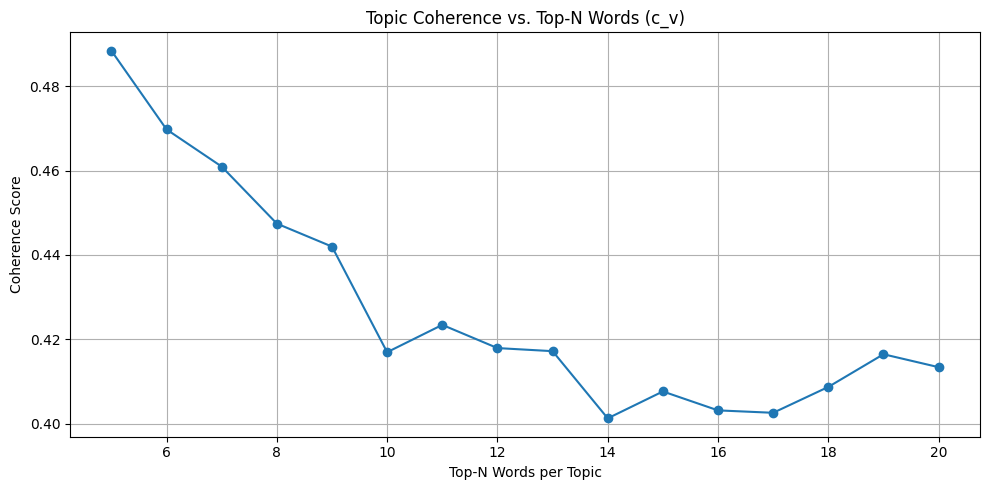

In [46]:
if __name__ == "__main__":
    main()
